In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sksurv.svm import FastSurvivalSVM
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

def map_to_scikit_surv(y):
    y = y.values.tolist()
    y1 = []
    y2 = []
    for w in y:
        y1.append(w[0])
        y2.append(w[1])
    y1 = list(map(bool, y1))
    ya = []
    for i in range(len(y1)):
        ya.append([y1[i], y2[i]])
    yy = pd.DataFrame(ya)
    y = yy.to_records(index=False)
    return y


def create_feature_importance(classifier, feature_names: list):
    coef = classifier.coef_.ravel()
    coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coef}).sort_values(by="Coefficient",
                                                                                        ascending=False)

    return coef_df


dataset_shapes = {
    'brca': '198x84',
    'gbsg2': '686x11',
    'whas500': '500x16',
    'microbiome': '150x1995'
}



Calculate central results using scikit-survival's FastSurvivalSVM

In [3]:
alpha = 0.0001

dataset_names = ['brca', 'gbsg2', 'whas500',
                 'microbiome'
                 ]
n_clients = [1, 3, 5]
n_splits = range(1, 10)


result_df = pd.DataFrame(columns=["dataset", "n_clients", "client", "split", "c_index"])

for dataset_name in dataset_names:
    print(dataset_name)
    print(pd.read_csv(f'central/{dataset_name}/data.csv').dropna().shape)
    for n_client in n_clients:
        clients = f'{n_client}_clients'
        for client_n in range(1, n_client + 1):
            client = f'client_{client_n}'
            for n_split in n_splits:
                path = f'federated-analysis/{dataset_name}/{clients}/{client}/data/split_{n_split}'
                train_data = pd.read_csv(f'{path}/train.csv')
                test_data = pd.read_csv(f'{path}/test.csv')
                pipe = Pipeline([('scaler', StandardScaler()), (
                    'ssvm', FastSurvivalSVM(rank_ratio=0, alpha=alpha, max_iter=50, fit_intercept=True, tol=0.00001))])
                pipe.fit(train_data.drop(['tte', 'event'], axis=1),
                         map_to_scikit_surv(train_data.loc[:, ['event', 'tte']]))
                coefs = pipe['ssvm'].coef_
                try:
                    c_index = pipe.score(test_data.drop(['tte', 'event'], axis=1),
                                         map_to_scikit_surv(test_data.loc[:, ['event', 'tte']]))
                except ValueError:
                    c_index = np.nan
                entry = pd.DataFrame.from_dict({
                    "dataset": [dataset_name],
                    "n_clients": [n_client],
                    "client": [client_n],
                    "split": [n_split],
                    "c_index": [c_index],
                })
                result_df = pd.concat([result_df, entry], ignore_index=True)
    
    data = pd.read_csv(f'central/{dataset_name}/data.csv')
    pipe.fit(data.drop(['tte', 'event'], axis=1), map_to_scikit_surv(data.loc[:, ['event', 'tte']]))
    joblib.dump(pipe['ssvm'], f'central/{dataset_name}/model.pkl')
result_df

brca
(198, 84)
gbsg2
(686, 11)
whas500
(500, 16)
microbiome
(150, 1995)


,dataset,n_clients,client,split,c_index
0,brca,1,1,1,0.741722
1,brca,1,1,2,0.544073
2,brca,1,1,3,0.682811
3,brca,1,1,4,0.696937
4,brca,1,1,5,0.615290
...,...,...,...,...,...
319,microbiome,5,5,5,0.777778
320,microbiome,5,5,6,0.695652
321,microbiome,5,5,7,0.705882
322,microbiome,5,5,8,0.625000


Read in federated results, generated via FeatureCloud

In [4]:
c_indices = []

for n_client in [3, 5]:
    clients = f'{n_client}_clients'
    for dataset_name in dataset_names:
        try:
            dfs = []
            for client_n in range(1, n_client + 1):
                client = f'client_{client_n}'
                for split in n_splits:
                    path = f'federated-analysis/{dataset_name}/{clients}/fc_normalization/fc_survival_svm/fc_survival_evaluation/{client}/data/split_{split}/global_scores.tsv'
                    df = pd.read_csv(path, sep='\t', header=None, index_col=0)
                    dfs.append(df)

            df = pd.concat(dfs, axis=1).T.reset_index(drop=True)

            c_index = df['mean c-index'].to_frame()
            c_index.columns = ['c_index']
            c_index['dataset'] = dataset_name
            c_index['n_clients'] = n_client
            c_index['client'] = 'fed'
            c_index = c_index.reset_index(drop=False)
            c_indices.append(c_index)

        except FileNotFoundError:
            pass

c_indices = pd.concat(c_indices)
c_indices.columns = ['split', 'c_index', 'dataset', 'n_clients', 'client']
c_indices = c_indices.loc[:, ['dataset', 'n_clients', 'client', 'split', 'c_index']]
c_indices['split'] = c_indices['split'] + 1
c_indices['c_index'] = c_indices['c_index'].astype(float)
display(c_indices)

,dataset,n_clients,client,split,c_index
0,brca,3,fed,1,0.756350
1,brca,3,fed,2,0.630217
2,brca,3,fed,3,0.709267
3,brca,3,fed,4,0.715814
4,brca,3,fed,5,0.640892
...,...,...,...,...,...
40,microbiome,5,fed,41,0.701335
41,microbiome,5,fed,42,0.710751
42,microbiome,5,fed,43,0.869804
43,microbiome,5,fed,44,0.739365


Read in federated results using secure aggreation, generated via FeatureCloud

In [5]:
c_indices_smpc = []

for n_client in [3, 5]:
    clients = f'{n_client}_clients'
    for dataset_name in dataset_names:
        try:
            dfs = []
            for client_n in range(1, n_client + 1):
                client = f'client_{client_n}'
                for split in n_splits:
                    path = f'smpc-analysis/{dataset_name}/{clients}/basic_normalization/fc_survival_svm/fc_survival_evaluation/{client}/data/split_{split}/global_scores.tsv'
                    df = pd.read_csv(path, sep='\t', header=None, index_col=0)
                    dfs.append(df)

            df = pd.concat(dfs, axis=1).T.reset_index(drop=True)
            c_index = df['mean c-index'].to_frame()
            c_index.columns = ['c_index']
            c_index['dataset'] = dataset_name
            c_index['n_clients'] = n_client
            c_index['client'] = 'fed + smpc'
            c_index = c_index.reset_index(drop=False)
            c_indices_smpc.append(c_index)

        except FileNotFoundError:
            pass

c_indices_smpc = pd.concat(c_indices_smpc)
c_indices_smpc.columns = ['split', 'c_index', 'dataset', 'n_clients', 'client']
c_indices_smpc = c_indices_smpc.loc[:, ['dataset', 'n_clients', 'client', 'split', 'c_index']]
c_indices_smpc['split'] = c_indices_smpc['split'] + 1
display(c_indices_smpc)

,dataset,n_clients,client,split,c_index
0,brca,3,fed + smpc,1,0.756350
1,brca,3,fed + smpc,2,0.630217
2,brca,3,fed + smpc,3,0.709267
3,brca,3,fed + smpc,4,0.715814
4,brca,3,fed + smpc,5,0.640892
...,...,...,...,...,...
40,microbiome,5,fed + smpc,41,0.701335
41,microbiome,5,fed + smpc,42,0.710751
42,microbiome,5,fed + smpc,43,0.869804
43,microbiome,5,fed + smpc,44,0.739365


In [6]:
for dataset_name in dataset_names:
    print(dataset_name)
    df = c_indices_smpc[c_indices_smpc['dataset'] == dataset_name]
    df = df[df['n_clients'] == 3]
    display(df.mean())

brca


/var/folders/7f/97wv261d0mq1gf_z901h4_5h0000gn/T/ipykernel_60965/1867705097.py:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(df.mean())


n_clients     3.00000
split        14.00000
c_index       0.68295
dtype: float64

gbsg2


/var/folders/7f/97wv261d0mq1gf_z901h4_5h0000gn/T/ipykernel_60965/1867705097.py:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(df.mean())


n_clients     3.000000
split        14.000000
c_index       0.660467
dtype: float64

whas500


/var/folders/7f/97wv261d0mq1gf_z901h4_5h0000gn/T/ipykernel_60965/1867705097.py:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(df.mean())


n_clients     3.000000
split        14.000000
c_index       0.758841
dtype: float64

microbiome


/var/folders/7f/97wv261d0mq1gf_z901h4_5h0000gn/T/ipykernel_60965/1867705097.py:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(df.mean())


n_clients     3.000000
split        14.000000
c_index       0.686297
dtype: float64

Create plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

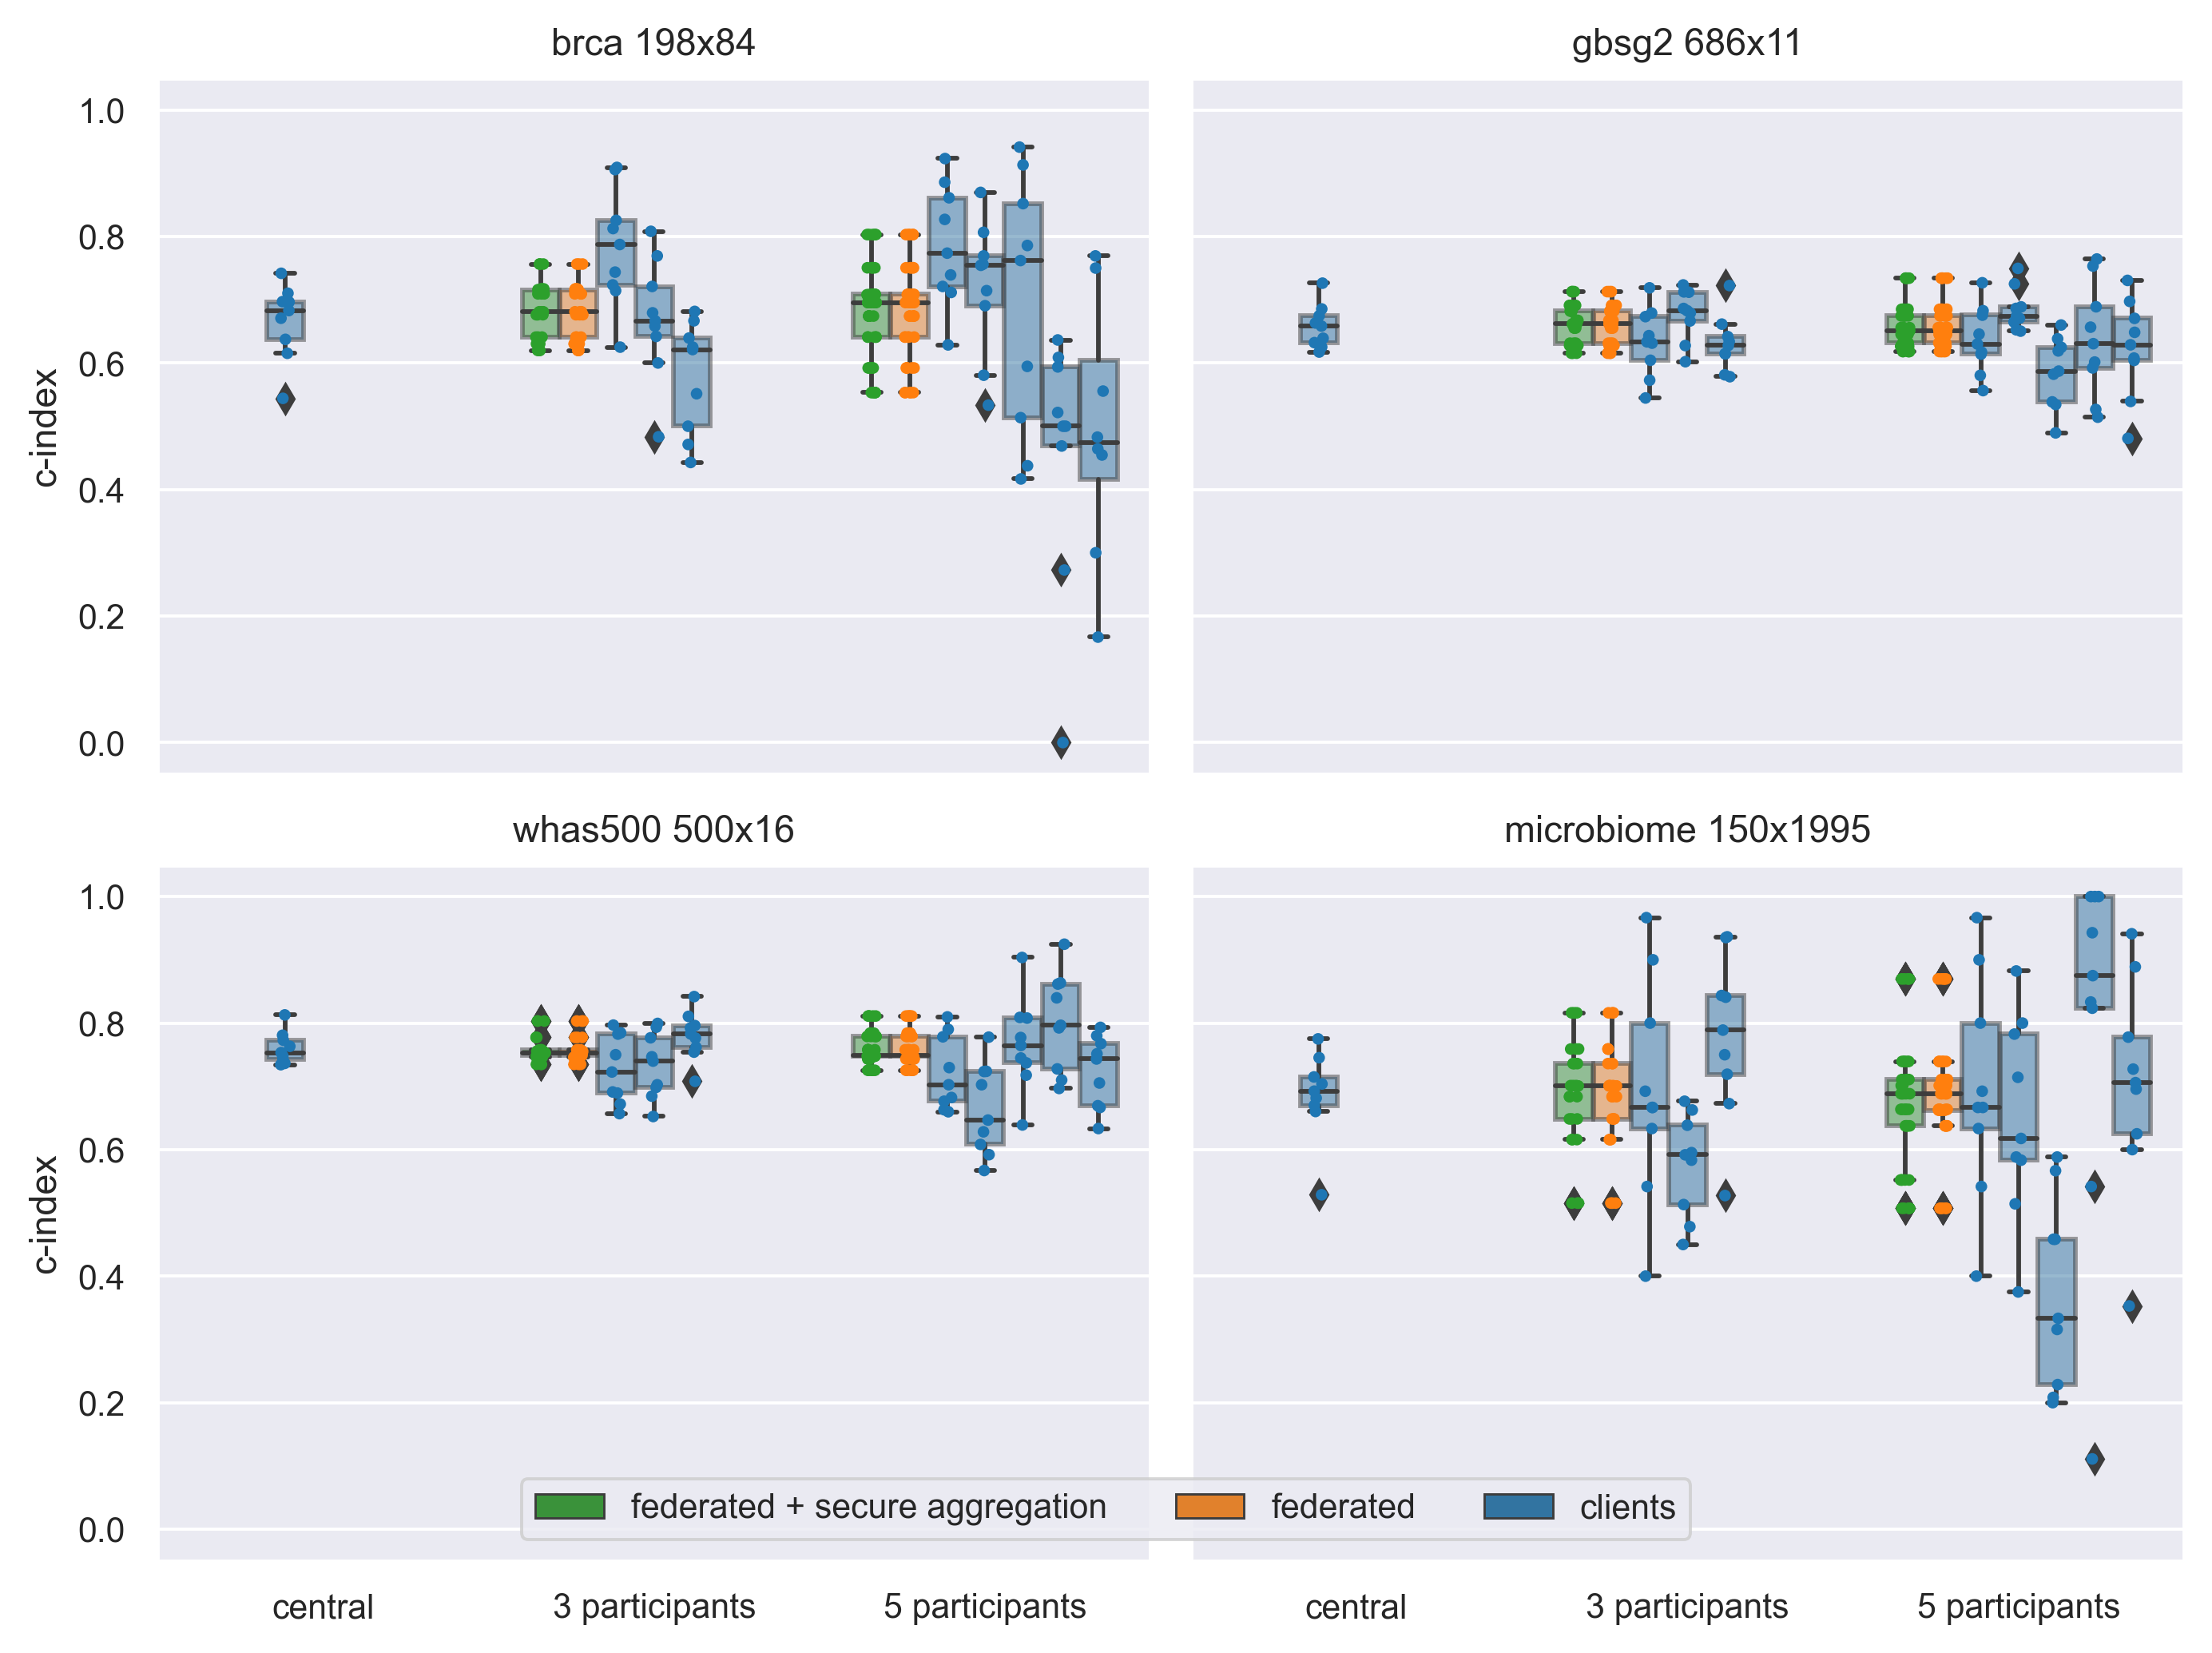

In [20]:
sns.set_style("whitegrid")
sns.set('paper')
sns.despine()

fig, axes = plt.subplots(2, 2, sharex='all', sharey='all', figsize=(8, 6), dpi=350)
row = 0
col = 0
handles = None
for dataset_name in dataset_names:
    ax = axes[row, col]
    ax.set_title(dataset_name + " " + dataset_shapes[dataset_name])
    df1 = result_df[result_df['dataset'] == dataset_name]
    df2 = c_indices[c_indices['dataset'] == dataset_name]
    df3 = c_indices_smpc[c_indices_smpc['dataset'] == dataset_name]
    df = pd.concat([df3, df2, df1]).reset_index()
    df = df.sort_values(['n_clients', 'client'])
    df['c_index'] = df['c_index'].astype(float)
    df['n_clients'] = df['n_clients'].astype(str)
    df['client'] = df['client'].astype(str)
    hue_order = ['fed', 'fed + smpc', '1', '2', '3', '4', '5']
    sns.boxplot(data=df, y='c_index', x='n_clients', hue='client', ax=ax, hue_order=hue_order, palette=['tab:green', 'tab:orange', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue'], boxprops=dict(alpha=.5))
    sns.stripplot(data=df, y='c_index', x='n_clients', hue='client', ax=ax, hue_order=hue_order, palette=['tab:green', 'tab:orange', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue'], dodge=True, size=3)
    if row == 0 and col == 0:
        handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    if col > 0:
        ax.set(ylabel=None)
    else:
        ax.set(ylabel='c-index')
    if row != 1:
        ax.set(xlabel=None)
    else:
        ax.set(xlabel=None)
        ax.set(xticklabels=['central', '3 participants', '5 participants'])
    if col < 1:
        col += 1
    else:
        row += 1
        col = 0
fig.legend(handles[:3], ['federated + secure aggregation', 'federated', 'clients'], loc='lower center', ncol=3, bbox_to_anchor=(0.5, 0.065))
plt.tight_layout()
fig.savefig('c_index.jpg', dpi=350)
fig.savefig('c_index.eps', dpi=350)
fig.savefig('c_index.svg', dpi=350)
plt.show()

Compare feature importances

In [8]:
coef_results = []
fi_results = {}
for dataset_name in dataset_names:
    coefs = []
    fis = []
    for n_client in [3, 5]:
        clients = f'{n_client}_clients'

        client = f'{n_client}_clients'
        path = f'federated-analysis/{dataset_name}/{client}/fc_normalization/fc_survival_svm/client_1'
        coef = pd.Series(joblib.load(path + '/model.pickle').coef_).to_frame()
        coef.columns = [client]
        coefs.append(coef)

        fi = pd.read_csv(path + '/feature_importance.tsv', sep='\t', index_col=0).drop('Coefficient', axis=1)
        fi.columns = [client]
        fis.append(fi)

    path = f'central/{dataset_name}/data.csv'
    data = pd.read_csv(path)
    X = data.drop(['event', 'tte'], axis=1)
    y = data.loc[:, ['event', 'tte']]
    pipe = Pipeline([('scaler', StandardScaler()), (
        'ssvm', FastSurvivalSVM(rank_ratio=0, alpha=alpha, max_iter=50, fit_intercept=True, tol=0.00001))])
    pipe.fit(X, map_to_scikit_surv(y))
    coef = pd.Series(pipe['ssvm'].coef_).to_frame()
    coef.columns = ['central']
    coefs.append(coef)

    coef_df = pd.concat(coefs, axis=1)
    coef_df['difference'] = coef_df['central'] - coef_df['5_clients']
    coef_df['dataset'] = dataset_name + " " + dataset_shapes[dataset_name]
    coef_df = coef_df.reset_index().rename({'index': 'coef_no'}, axis=1)
    coef_results.append(coef_df)

    fi = create_feature_importance(pipe['ssvm'], feature_names=X.columns).drop('Coefficient', axis=1)
    fi.columns = ['central']
    fis.append(fi)
    fi_df = pd.concat(fis, axis=1)
    fi_df['match'] = fi_df['central'] == fi_df['5_clients']
    fi_result = fi_df.groupby('match').count().loc[True, 'central']
    fi_results[dataset_name] = fi_result*100 /len(X.columns)


fi_data = pd.DataFrame(fi_results, index=['match (%)'])
fi_data.to_csv('match.csv')
coef_data = pd.concat(coef_results)
coef_data = coef_data.reset_index(drop=True)

coef_data['method'] = 'federated'
display(coef_data)


,coef_no,3_clients,5_clients,central,difference,dataset,method
0,0,0.000947,0.000947,0.000955,0.000008,brca 198x84,federated
1,1,0.001485,0.001485,0.001506,0.000021,brca 198x84,federated
2,2,-0.000724,-0.000724,-0.000705,0.000019,brca 198x84,federated
3,3,-0.001605,-0.001605,-0.001561,0.000045,brca 198x84,federated
4,4,0.002531,0.002531,0.002621,0.000090,brca 198x84,federated
...,...,...,...,...,...,...,...
2093,1988,0.000000,0.000000,0.000000,0.000000,microbiome 150x1995,federated
2094,1989,0.000691,0.000691,0.000888,0.000197,microbiome 150x1995,federated
2095,1990,0.001298,0.001298,0.001367,0.000070,microbiome 150x1995,federated
2096,1991,-0.001409,-0.001409,-0.001436,-0.000027,microbiome 150x1995,federated


In [9]:
coef_results = []
fi_results = {}
for dataset_name in dataset_names:
    coefs = []
    fis = []
    for n_client in [3, 5]:
        clients = f'{n_client}_clients'

        client = f'{n_client}_clients'
        path = f'smpc-analysis/{dataset_name}/{client}/basic_normalization/fc_survival_svm/client_1'
        coef = pd.Series(joblib.load(path + '/model.pickle').coef_).to_frame()
        coef.columns = [client]
        coefs.append(coef)

        fi = pd.read_csv(path + '/feature_importance.tsv', sep='\t', index_col=0).drop('Coefficient', axis=1)
        fi.columns = [client]
        fis.append(fi)

    path = f'central/{dataset_name}/data.csv'
    data = pd.read_csv(path)
    X = data.drop(['event', 'tte'], axis=1)
    y = data.loc[:, ['event', 'tte']]
    pipe = Pipeline([('scaler', StandardScaler()), (
        'ssvm', FastSurvivalSVM(rank_ratio=0, alpha=alpha, max_iter=50, fit_intercept=True, tol=0.00001))])
    pipe.fit(X, map_to_scikit_surv(y))
    coef = pd.Series(pipe['ssvm'].coef_).to_frame()
    coef.columns = ['central']
    coefs.append(coef)

    coef_df = pd.concat(coefs, axis=1)
    coef_df['difference'] = coef_df['central'] - coef_df['5_clients']
    coef_df['dataset'] = dataset_name + " " + dataset_shapes[dataset_name]
    coef_df = coef_df.reset_index().rename({'index': 'coef_no'}, axis=1)
    coef_results.append(coef_df)

    fi = create_feature_importance(pipe['ssvm'], feature_names=X.columns).drop('Coefficient', axis=1)
    fi.columns = ['central']
    fis.append(fi)
    fi_df = pd.concat(fis, axis=1)
    fi_df['match'] = fi_df['central'] == fi_df['5_clients']
    fi_result = fi_df.groupby('match').count().loc[True, 'central']
    fi_results[dataset_name] = fi_result*100 /len(X.columns)


fi_data_smpc = pd.DataFrame(fi_results, index=['match (%)'])
coef_data_smpc = pd.concat(coef_results)
coef_data_smpc = coef_data.reset_index(drop=True)
coef_data_smpc['method'] = 'federated + secure aggregation'

display(coef_data_smpc)

,coef_no,3_clients,5_clients,central,difference,dataset,method
0,0,0.000947,0.000947,0.000955,0.000008,brca 198x84,federated + secure aggregation
1,1,0.001485,0.001485,0.001506,0.000021,brca 198x84,federated + secure aggregation
2,2,-0.000724,-0.000724,-0.000705,0.000019,brca 198x84,federated + secure aggregation
3,3,-0.001605,-0.001605,-0.001561,0.000045,brca 198x84,federated + secure aggregation
4,4,0.002531,0.002531,0.002621,0.000090,brca 198x84,federated + secure aggregation
...,...,...,...,...,...,...,...
2093,1988,0.000000,0.000000,0.000000,0.000000,microbiome 150x1995,federated + secure aggregation
2094,1989,0.000691,0.000691,0.000888,0.000197,microbiome 150x1995,federated + secure aggregation
2095,1990,0.001298,0.001298,0.001367,0.000070,microbiome 150x1995,federated + secure aggregation
2096,1991,-0.001409,-0.001409,-0.001436,-0.000027,microbiome 150x1995,federated + secure aggregation


In [10]:
fi_data_overall = pd.concat([fi_data, fi_data_smpc])
fi_data_overall.index = ['federated', 'federated + secure aggregation']
fi_data_overall.to_csv('match.csv')

In [11]:
coefs_overall = pd.concat([coef_data, coef_data_smpc])
coefs_overall['difference'] = coefs_overall['difference'].apply(lambda x: x)
coefs_overall

,coef_no,3_clients,5_clients,central,difference,dataset,method
0,0,0.000947,0.000947,0.000955,0.000008,brca 198x84,federated
1,1,0.001485,0.001485,0.001506,0.000021,brca 198x84,federated
2,2,-0.000724,-0.000724,-0.000705,0.000019,brca 198x84,federated
3,3,-0.001605,-0.001605,-0.001561,0.000045,brca 198x84,federated
4,4,0.002531,0.002531,0.002621,0.000090,brca 198x84,federated
...,...,...,...,...,...,...,...
2093,1988,0.000000,0.000000,0.000000,0.000000,microbiome 150x1995,federated + secure aggregation
2094,1989,0.000691,0.000691,0.000888,0.000197,microbiome 150x1995,federated + secure aggregation
2095,1990,0.001298,0.001298,0.001367,0.000070,microbiome 150x1995,federated + secure aggregation
2096,1991,-0.001409,-0.001409,-0.001436,-0.000027,microbiome 150x1995,federated + secure aggregation


<Figure size 640x480 with 0 Axes>

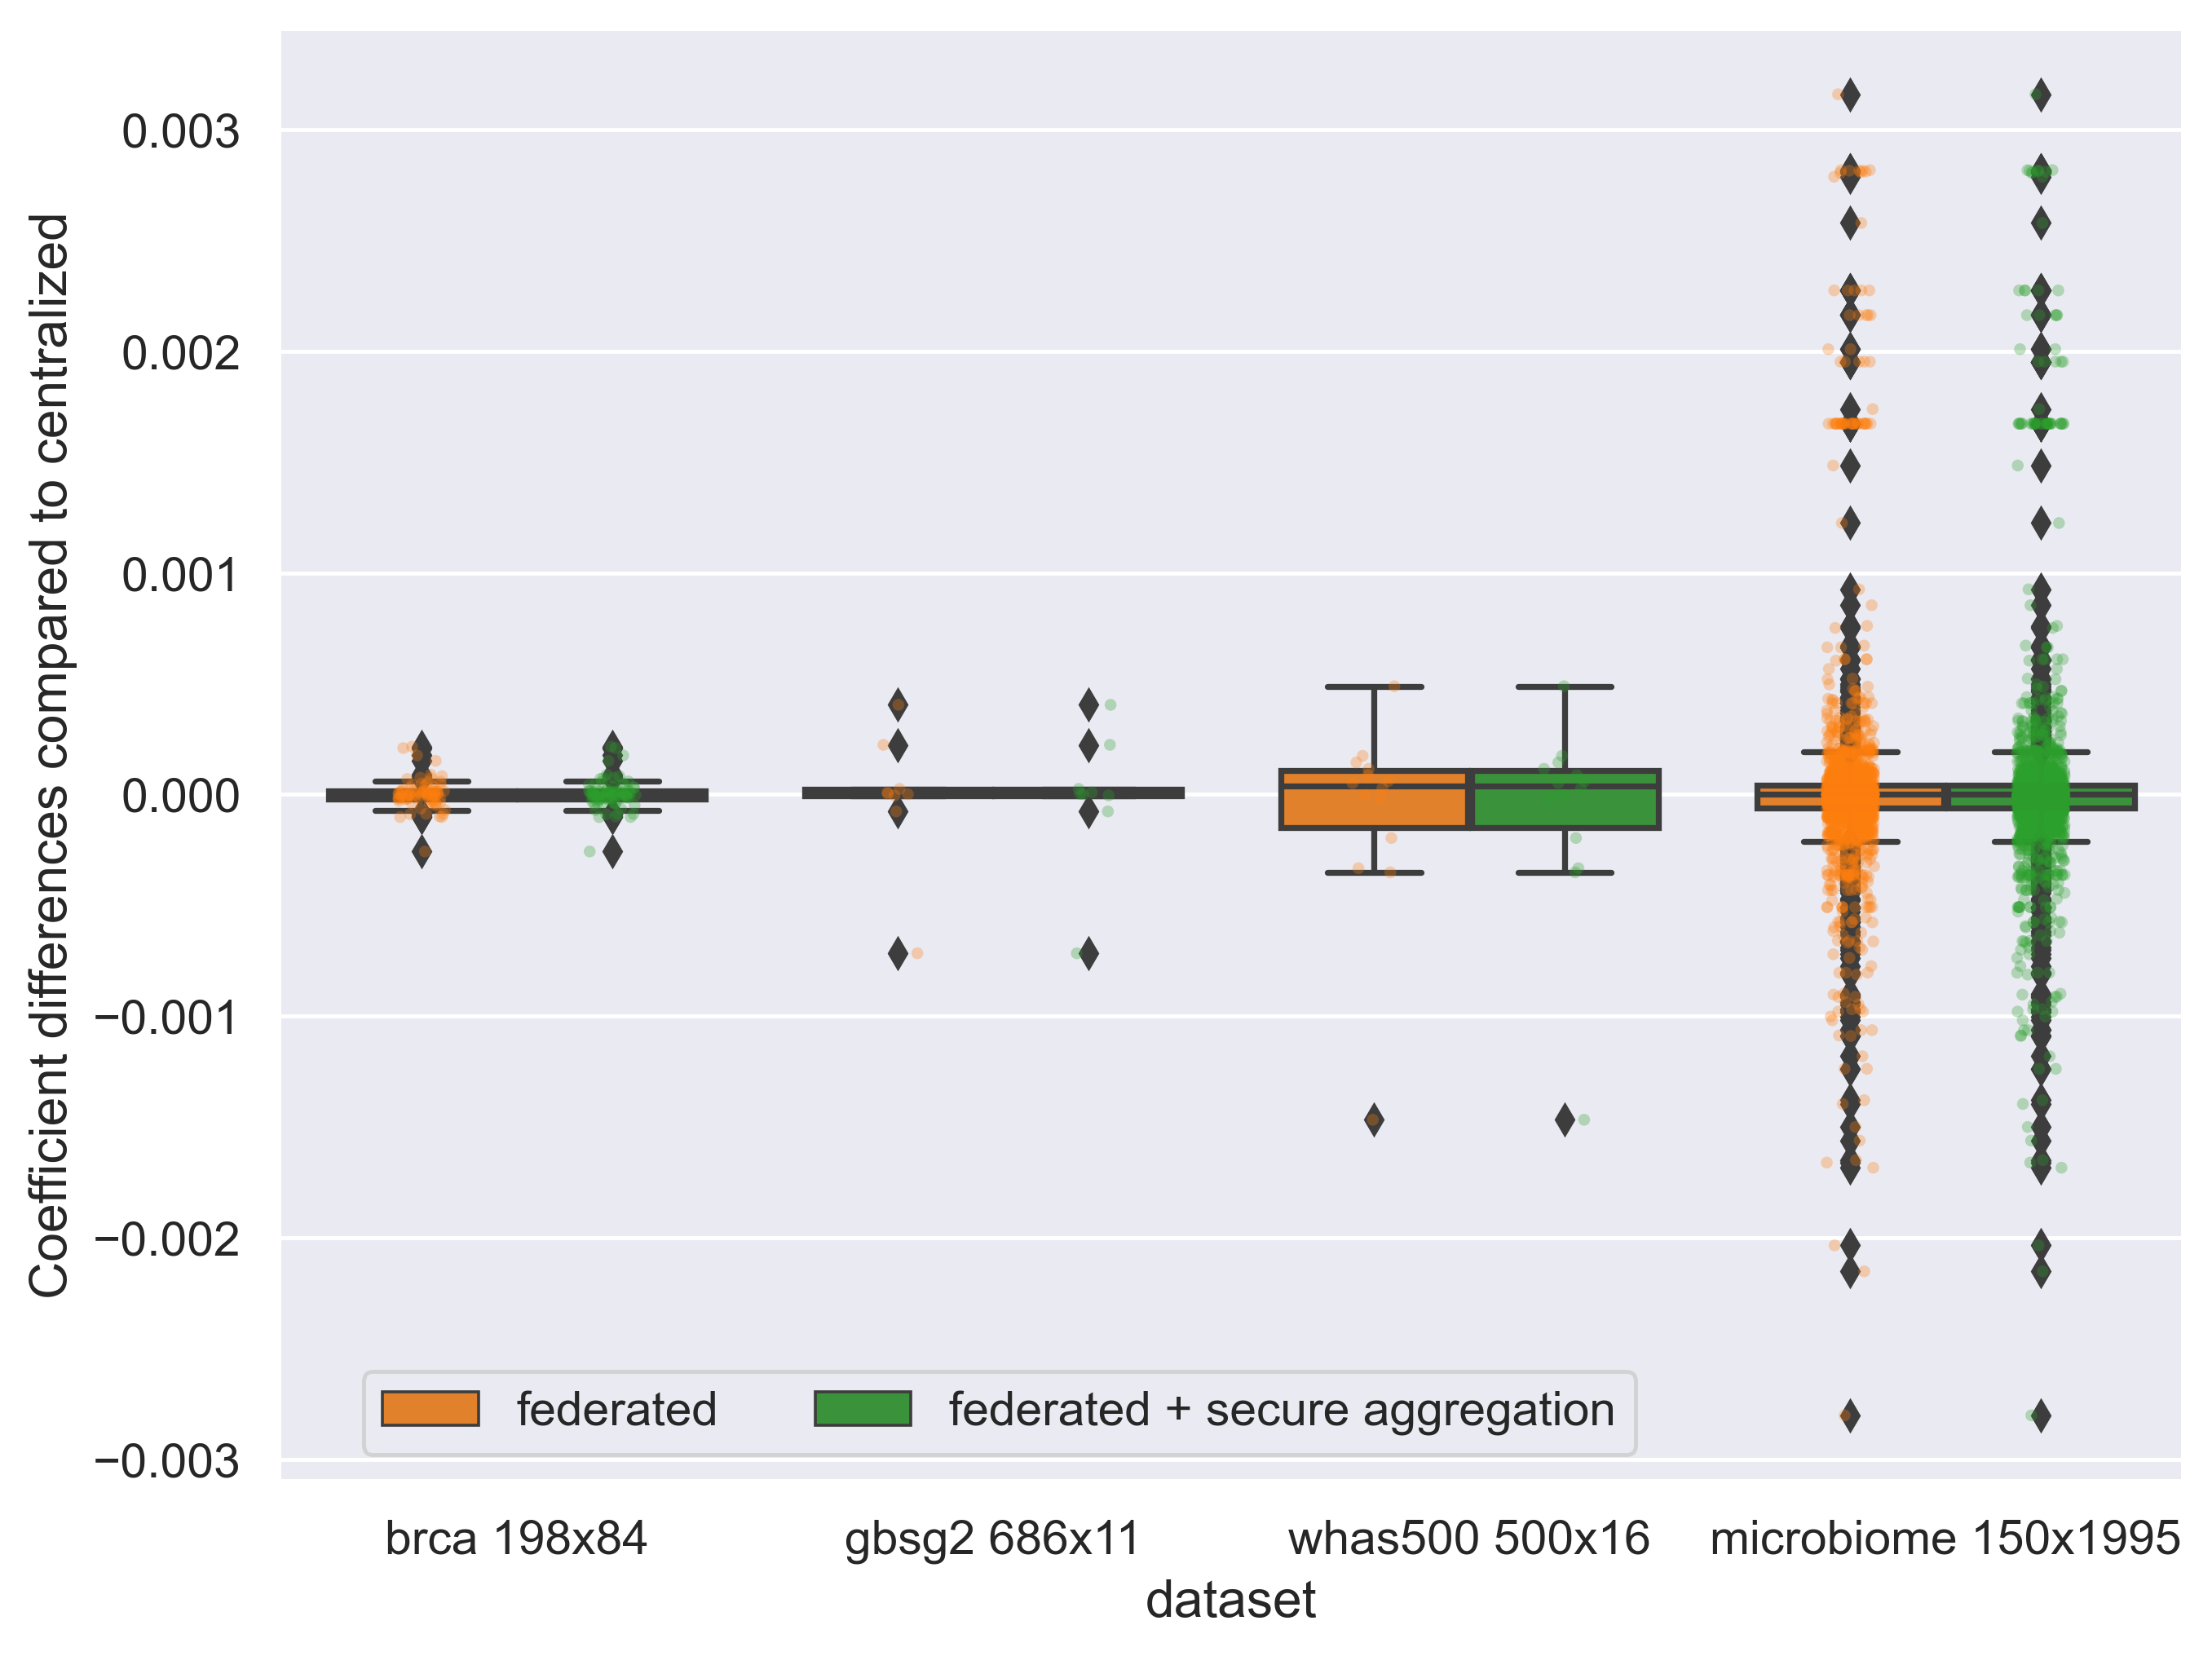

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [12]:
sns.set_style("whitegrid")
sns.despine()
sns.set(font_scale=1.1)

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=350)
sns.stripplot(data=coefs_overall.reset_index(), y='difference', x='dataset', hue='method', palette=['tab:orange', 'tab:green'], dodge=True, size=3, alpha=0.3)
sns.boxplot(data=coefs_overall.reset_index(), y='difference', x='dataset', hue='method', palette=['tab:orange', 'tab:green'])

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles[2:], labels[2:], loc='lower center', ncol=2, bbox_to_anchor=(0.45, 0.12))
ax.set(ylabel='Coefficient differences compared to centralized')
plt.tight_layout()
plt.show()
fig.savefig('coefs.jpg', dpi=350)
fig.savefig('coefs.eps', dpi=350)
fig.savefig('coefs.svg', dpi=350)

In [13]:
def plot_fi(coef_df: pd.DataFrame, top_features: int = 10):
    def colors_from_values(values, palette_name):
        # normalize the values to range [0, 1]
        normalized = (values - min(values)) / (max(values) - min(values))
        # convert to indices
        indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
        # use the indices to get the colors
        palette = sns.color_palette(palette_name, len(values))
        return np.array(palette).take(indices, axis=0)

    sns.set("talk", font_scale=1.2)
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(1, 1, figsize=(top_features, round(top_features / 2, 1)))
    sns.barplot(data=coef_df, x="Feature", y="Coefficient", ax=ax,
                palette=colors_from_values(coef_df['Coefficient'].abs(), "flare"))
    ax.legend([], [], frameon=False)
    ax.xaxis.set_tick_params(rotation=90)

    return fig

In [14]:
dfs = []

for dataset_name in dataset_names:
    print(dataset_name)
    central_model = joblib.load(f'central/{dataset_name}/model.pkl').coef_
    three_client_model = joblib.load(f'federated-analysis/{dataset_name}/3_clients/fc_normalization/fc_survival_svm/client_1/model.pickle').coef_
    df = pd.DataFrame([central_model, three_client_model]).T
    df['diff'] = (df[0] - df[1]).abs()
    dfs.append(df)
    print('Max', df.max()['diff'])
    print('Mean', df.mean()['diff'])

print('Overall')
dfs = pd.concat(dfs)
print('Max', dfs.max()['diff'])
print('Mean', dfs.mean()['diff'])

brca
Max 0.0002570183254213317
Mean 4.019957279318999e-05
gbsg2
Max 0.0007165026803974562
Mean 0.00016291311106119297
whas500
Max 0.0014679310180090617
Mean 0.00025127777465091785
microbiome
Max 0.0031609183060860684
Mean 0.00016869535454910916
Overall
Max 0.0031609183060860684
Mean 0.00016419938676362237


In [20]:
[0.00016869535454910916, 0.00025127777465091904]

[0.00016869535454910916, 0.00025127777465091904]